# Handwritten Digit Recognition app
https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/

Data: MNIST dataset

Model: <a href="https://data-flair.training/blogs/convolutional-neural-networks-tutorial/">Convolutional Neural Networks</a>

Theory: <a href="https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training/neural-networks?autoAdvance=true&autoSkip=true&autoplay=true&resume=false&u=36492188">"Neural_Networks_and_Convolutional_Neural_Networks_Essential_Training"</a> LinkedIn course by Jonathan Fernandes.

Libraries: Keras, Tkinter for building GUI.

In the end, a GUI is built where one can draw a digit and recognize it straight away. If the image is misclassified, one can provide correct label and save the handwritten image and label. Corrections can then be added to the main image dataset for model re-training.

## 1. Libraries and MNIST dataset
MNIST dataset contains 60,000 training images of handwritten digits from 0 to 9 and 10,000 images for testing. Images have black background and white-gray digits. Digits are represented as a 28×28 matrix where each cell contains grayscale pixel value from 0 to 255. There are 10 classes, one for each digit.

The Keras library already contains some datasets and MNIST is one of them. So we can easily import the dataset and start working with it. The `mnist.load_data()` method returns us the training data, its labels and also the testing data and its labels.
#### Import packages

In [1]:
%reset -f
import os
os.chdir('C:/Sereda/Lectures/Springboard/Projects/DigitRecognition_CNN')

#pip install tensorflow
#pip install keras
#pip install pillow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # save image array to csv
# to view plots in notebook
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D   # convolutional NNs
from keras import backend as K
#from keras import utils as np_utils
#from tensorflow.keras import utils as np_utils
#from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical
#import tensorflow as tf

from PIL import Image, ImageGrab
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
# GUI
from keras.models import load_model
from tkinter import *
import tkinter as tk
import win32gui

#### Load the data

In [2]:
# the data, split between train and test sets
print("MNIST dataset")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

MNIST dataset
X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


#### Plot an image to see if data is correct

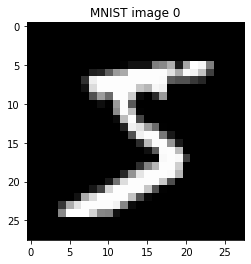

Label = 5


In [3]:
n = 0 # image number
img = X_train[n,:,:].astype('float32')/255
plt.imshow(img, cmap='gray')
plt.title(f'MNIST image {n}')
plt.show()
print(f"Label = {y_train[n]}")

## 2. Preprocessing
The image data cannot be fed directly into the model so we need to perform some operations and process the data to make it ready for our neural network. The dimension of the training data is (60000,28,28). The CNN model will require one more dimension so we reshape the matrix to shape (60000,28,28,1).
#### Training data format

In [4]:
# Keep image data as a matrix or convert to vector?
mx = False # True/False: If false - as 28^2 vector for NN, if true - as 28 x 28 matrix for CNN
sy = X_test.shape[1]; sx = X_test.shape[2]; # image sizes
if mx:
    print(f"Images as {sy} x {sx} matrixes for training")
    input_shape = (sy, sx, 1)
else:
    print(f"Images as {sy*sx}-component vectors for training")
    input_shape = (sy*sx, )
    X_train = X_train.reshape(-1,sy*sx)
    X_test = X_test.reshape(-1,sy*sx)
    print("New training size, X_train:",X_train.shape)
    print("New test size, X_test:",X_test.shape)

Images as 784-component vectors for training
New training size, X_train: (60000, 784)
New test size, X_test: (10000, 784)


#### Add manually labeled images
If some corrections were saved during previous digit recognitions, read them to add to the training dataset. 

Reading saved misclassified images with available labels: images.csv
Adding manually labeled images to MNIST training set, X_labeled: (69, 784)
New training size, X_train: (60069, 784)
Reading saved correct labels: labels.csv
Adding manual labels to MNIST training labels, y_labeled: (69, 1)
New training labels size: (60069, 1)
Last label: [0.]
Last image:


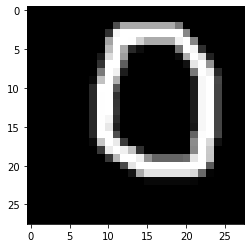

In [757]:
saved_images = 'images.csv' # (n, sy*sx) n vectors with sy*sx components of 0-255, no header
saved_labels = 'labels.csv' # scalars, no header

if os.path.exists(saved_images):
    print("Reading saved misclassified images with available labels:",saved_images)
    X_labeled = pd.read_csv(saved_images, header=None)
    print("Adding manually labeled images to MNIST training set, X_labeled:",X_labeled.shape)
    if mx:
        X_train = np.concatenate( (X_train, np.array(X_labeled).reshape(-1,sy,sx)) )
    else:
        X_train = np.concatenate( (X_train, np.array(X_labeled)) )
    print("New training size, X_train:",X_train.shape)
else: print("No saved labeled images")

if os.path.exists(saved_labels):
    print("Reading saved correct labels:",saved_labels)
    y_labeled = pd.read_csv(saved_labels, header=None)
    print("Adding manual labels to MNIST training labels, y_labeled:",y_labeled.shape)
    #y_train = np.concatenate( (y_train, np.array(y_labeled).reshape(-1)) )
    # Do we need to add last dimension 1 to y_train?
    y_train = np.concatenate((y_train.reshape(-1,1), np.array(y_labeled).ravel().reshape(-1,1)))
    print("New training labels size:",y_train.shape)
else: print("No saved manual labels")

# Verify
print("Last label:",y_train[-1])
print("Last image:")
plt.imshow(X_train.reshape(-1,sy,sx)[-1], cmap='gray');

#### Scale predictors from 0 to 1 and one-hot encode labels

In [5]:
X_train = X_train.astype('float32')/255 # Convert to float to avoid problems during rescaling to 0-1.
# Could do 1-... to invert image and make white background with black digits.
X_test = X_test.astype('float32')/255 # 1-...
#print("min. X_train[0] =",np.min(X_train[0])) # 0-1
#print("max. X_train[0] =",np.max(X_train[0]))
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes=10   # 10 digits 0-9
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (60000, 784)
X_test: (10000, 784)
60000 train samples
10000 test samples
y_train: (60000, 10)
y_test: (10000, 10)


## 3. Neural Network models in Keras
### 3.1 NN model

In [6]:
# Create model
nn = Sequential()
# Add the first hidden layer
#nn.add(Dense(50, activation='relu', input_shape=(28*28,))) # 50 nodes, ReLU activation function, input_shape indicated only once
nn.add(Dense(50, activation='relu', input_shape=(sy*sx,))) # 50 nodes, ReLU activation function, input_shape indicated only once
# Add the second hidden layer
nn.add(Dense(50, activation='relu'))
# Add the output layer
nn.add(Dense(10, activation='softmax'))

# Compile model
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','AUC'])
nn.summary()

print("Explanation of the number of weights:")
print("1st layer's parameters:",50*(sx*sy+1)) # Each of the 50 nodes of layer 1 takes sx*sy inputs (pixels here) +1 due to bias
print("2nd layer's parameters:",50*(50+1)) # Each of the 50 nodes of layer 2 takes 50 inputs + 1 bias
print("output layer's parameters:",num_classes*(50+1)) # Each of the 10 output classes takes 50 inputs + 1 bias

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Explanation of the number of weights:
1st layer's parameters: 39250
2nd layer's parameters: 2550
output layer's parameters: 510


### 3.2 Convolutional Neural Networks
A CNN model generally consists of convolutional and pooling layers. It works better for data that are represented as grid structures,- this is the reason why CNN works well for image classification problems. One image is distinguishable from another by its spatial structure. Areas close to each other are highly significant for an image.

However, fully connected neural networks typically don't work well on large images, since they don't scale well with image size. Example: 32 * 32 * 3 image = 3072 weights; 200 * 200 * 3 = 120000 weights. This large number of parameters can quickly lead to overfitting. One could work with smaller version of images, but one would lose information.

The dropout layer is used to deactivate some of the neurons and while training, it reduces overfitting of the model.

We will then compile the model with the Adadelta optimizer.
However, beware of poor scaling of compute time with image size.

#### Convolutions
* <b>Kernel</b> (filter, or matrix): 3 x 3 or 5 x 5. Center element of the kernel is placed over the source pixel. The source pixel is then replaced with the sum of elemenwise products in the kernel and corresponding nearby source pixels.
* Convolve it over the image in all possible ways.
This gives 2D <b>activation map</b>. Convolving decreases the spatial size.

<b>Zero Padding</b>

Using n x n filter, we lose n-1 pixels in each of the 2 dimensions each time. To preserve the spatial size of the input (do not lose pixels), pad with 0's.

F: size of filter<br>
S: stride<br>
N: size of image<br>
P: amount of padding<br>
The image output size is given by $\frac{N-F+2P}{S}+1$

#### Pooling
<b>Max Pooling</b>

Keep only a maximal value from each block, e.g. 2 x 2.

<b>Average Pooling</b>

Keep only an average value from each block.
Why to use the pooling? To progressively reduce the size and chances of overfitting. Max pooling is more popular, as convolutions "light up" when they detect a particular feature in a region of an image. When downsampling, it makes sense to preserve the parts that were most activated.

#### Dropout
<b>Dropout</b> to prevent overfitting.
* Randomly kill each neuron in layer of a training set with probability p, typically 0.5 (half of the neurons in a layer are dropped during the training). Therefore, the network cannot rely on activation of any set of hidden units, since they may be turned off at any time during tarining, and the model is forced to learn more general and more robust patterns from the data.
We don't use dropout during validation of the data.

In [7]:
if mx:
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    cnn.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy']) #optimizer=tf.keras.optimizers.Adadelta()
    cnn.summary()
    
    print("Explanation of the number of weights:")
    print("1st layer's parameters:",32*((28-3+2*1)//3+1)) # convolutions*nodes: Filter size = 3, Padding = 1, Stride = 3
    print("2nd layer's parameters:", (32*((26-3+2*1)//3+1) + 1)*64)
    print("6th layer's parameters:", (9216+1)*256)
    print("output layer's parameters:", (256+1)*10)

### 3.3 Choose / load / train / save the model

In [7]:
# Choose model
if mx:
    model = cnn
    model_fn = 'cnn.e200.h5' # HDF5 format
else:
    model = nn
    model_fn = 'nn.e200.h5'

# If the model was previously trained, read the weights
if os.path.isfile(model_fn):
    print("Reading model weights:",model_fn)
    model.load_weights(model_fn)

Reading model weights: nn.e200.h5


The `model.fit()` function of Keras will start the training of the model. It takes the <b>training data, validation data, epochs,</b> and <b>batch size</b>. It takes some time to train the model. After training, we save the weights and model definition in the ‘mnist.h5’ file.

In [672]:
#print("input_shape =",input_shape)
#X_train_sc = X_train.reshape(-1,sy*sx)
#X_test_sc = X_test.reshape(-1,sy*sx)
#print("X_train_sc:",X_train_sc.shape)
#print("X_test_sc:",X_test_sc.shape)

input_shape = (784,)
X_train_sc: (60000, 784)
X_test_sc: (10000, 784)


In [763]:
print("Train model")
#model.fit(X_train, y_train, epochs=1)
history_model = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test, y_test), verbose=1);
print(history_model.params)
print(history_model.history)
pd.DataFrame(history_model.history).to_csv('performance/nn_relu50_relu50.csv', index=None) # Save training performance

Train model
Epoch 1/200
470/470 [==============================] - 1s 2ms/step - loss: 0.0078 - accuracy: 0.9988 - auc: 0.9998 - val_loss: 0.2570 - val_accuracy: 0.9747 - val_auc: 0.9917
Epoch 2/200
470/470 [==============================] - 1s 2ms/step - loss: 0.0024 - accuracy: 0.9994 - auc: 0.9999 - val_loss: 0.2819 - val_accuracy: 0.9724 - val_auc: 0.9904
Epoch 3/200
470/470 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 0.9985 - auc: 0.9999 - val_loss: 0.2590 - val_accuracy: 0.9751 - val_auc: 0.9915
Epoch 4/200
470/470 [==============================] - 1s 2ms/step - loss: 0.0034 - accuracy: 0.9989 - auc: 0.9999 - val_loss: 0.2557 - val_accuracy: 0.9757 - val_auc: 0.9914
Epoch 5/200
470/470 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9992 - auc: 1.0000 - val_loss: 0.2578 - val_accuracy: 0.9735 - val_auc: 0.9915
Epoch 6/200
470/470 [==============================] - 1s 2ms/step - loss: 2.8345e-04 - accuracy: 1.0000 - auc: 1

KeyboardInterrupt: 

In [455]:
print("Save model:", model_fn)
model.save(model_fn)

Save model: cnn.e200.h5


### 3.4. Evaluate the model
We have 10,000 images in our dataset which will be used to evaluate how good our model works. The testing data was not involved in the training of the data therefore, it is new data for our model. The MNIST dataset is well balanced so we can get around 99% accuracy.

In [8]:
# NN model training history
try: history_model.head(1)
except NameError:
    history_model = pd.read_csv('performance/nn_relu50_relu50.csv', header='infer')
history_model.head(2)

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.172785,0.949300,0.996970,0.147412,0.9533,0.997827
1,0.130231,0.961433,0.998029,0.129135,0.9614,0.997835


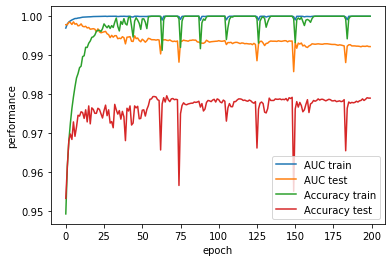

In [9]:
# Plot training performance
plt.plot(history_model['auc'])
plt.plot(history_model['val_auc'])
plt.plot(history_model['accuracy'])
plt.plot(history_model['val_accuracy'])
plt.legend(['AUC train', 'AUC test', 'Accuracy train', 'Accuracy test']);
plt.xlabel('epoch');
plt.ylabel('performance');

In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # nn.e200.h5

Test loss: 0.24559350311756134
Test accuracy: 0.9758999943733215


In [544]:
# mx==True
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # cnn.e200.h5

Test loss: 0.11838948726654053
Test accuracy: 0.9645000100135803


### 3.5. Enhancements to CNNs
* <b>Image augmentation</b>: Taking images in training set and manipulating them to create many altered versions of the same image. There are more images for our model to train on.
Image manipulations make our model more robust. The distortions are random combinations of shifts, scaling, skewing, and compression.

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False) #True

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False) #True

jf_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=False) #True

In [815]:
# Manually labaled images convert to matrix
try:
    X_labeled.head(1)
    X_labeled_mx = np.array(X_labeled).reshape(-1,28,28)
    X_labeled_mx.shape
    n=0 # image number
    print(y_labeled.iloc[n][0]) # correct label
    plt.imshow(X_labeled_mx[n], cmap='gray'); # visual verification
    try: y_labeled.shape
    except NameError:
        if os.path.exists(saved_labels):
            print("Reading saved correct labels:",saved_labels)
            y_labeled = pd.read_csv(saved_labels, header=None)
            # Save images
            for n in range(X_labeled_mx.shape[0]):
                # Convert numeric array to image
                im = Image.fromarray((X_labeled_mx[n]).astype(np.uint8))
                # Save image: subfolders are integer labels, create in advance!
                im.save('images_train/'+str(int(y_labeled.iloc[n][0]))+'/'+str(n)+'.png')
        else:
            print(f"Error: {saved_labels} does not exist!")
            print("Initialize y_labeled with image labels in vector form.")
    else:
        print(f"y_labeled was initialize earlier")
except NameError:
    print("No manually added data")

No manually added data


#### Check on a sample to see the image generators work as expected

In [816]:
train_generator = train_datagen.flow_from_directory('images_train/', target_size=(150,150), save_to_dir='images_augm')

Found 50 images belonging to 10 classes.


#### Generate variations of the images

In [492]:
i=0
for batch in train_datagen.flow_from_directory('images_train/', target_size=(150,150), save_to_dir='images_augm'):
    i += 1
    if(i>10): break

Found 50 images belonging to 10 classes.


## 4. Create GUI to predict digits
Here an interactive window (GUI) is created where one can draw a digit using mouse and get a prediction of what this digit is. The GUI is implemented using Tkinter library that comes in the Python standard library. The `App` class is responsible for building the GUI for our app. It has a canvas where one can draw by capturing the mouse event. Functions are triggered by pushing control buttons: button 'Clear' clears canvas and button 'Recognise' activates the function `predict_digit()` to recognize the digit. This function takes the image as input and then uses the trained model to predict the digit. The predicted label and its probability percentage are displayed.
### 4.1 Basic GUI

In [14]:
#https://docs.python.org/3/library/tkinter.html
def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    #reshaping to support our model input and normalizing
    if mx: img = img.reshape(1,28,28,1)
    else: img = img.reshape(1,28*28,1)
    img = 1 - img/255.0
    #predicting the class
    res = model.predict([img])[0]
    return np.argmax(res), max(res)

class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        self.width = self.height = 60 # sizes of handwritten digit box
        # Creating elements
        #self.canvas = tk.Canvas(self, width=28, height=28, bg = "white", cursor="cross")
        self.canvas = tk.Canvas(self, width=self.width, height=self.height, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.button_classify = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.button_classify.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        #self.canvas.bind("<Motion>", self.start_pos)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    def clear_all(self):
        self.canvas.delete("all")
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit, acc = predict_digit(im)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=self.width//28
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')

#if mx: model = load_model('cnn.e200.h5')
#else: model = load_model('nn.e200.h5')
app = App()
mainloop()

### 4.2 GUI with added functionality
<b>Instructions:<b><br>
* If a handwritten digit is misclassified, press "Fix" button to add the image to train set, which will be concatenated with the MNIST data before next training cycle.
* Type in correct label and press "Get label" button to add the label to train set.
* Press "Save corrections" button to save manually labeled images and labels, and clean memory.

Accuracy % is displayed on the bottom right.

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Admin\AppData\Local\Temp/ipykernel_18820/3602344524.py", line 57, in clear_all
    self.acc_running = self.n_ca/self.n_aa
ZeroDivisionError: division by zero


0 [0.]
1 [0. 1.]
2 [0. 1. 8.]
3 [0. 1. 8. 9.]


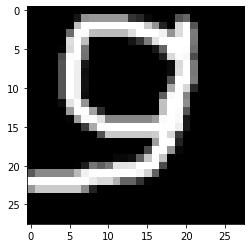

In [11]:
#https://docs.python.org/3/library/tkinter.html
#https://datatofish.com/entry-box-tkinter/

#model = load_model('nn.e200.h5')
def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    #reshaping to support our model input and normalizing
    if mx: img = img.reshape(1,28,28,1)
    else: img = img.reshape(1,28*28,1)
    img = img/255.0 # make pixels 0 to 1
    img = 1 - img # negate: black background, white digit (as in training data)
    #plt.imshow(img, cmap='gray');
    #predicting the class
    res = model.predict([img])[0]
    return np.argmax(res), max(res)
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        # Parameters
        self.x = self.y = 0
        self.width = self.height = 60 # sizes of handwritten digit box
        self.i = 0 # counter of fixed labels
        self.cl = np.array([], dtype='float32') # corrected labels
        self.images_misclass = pd.DataFrame([], dtype='int') # incorrectly classified images
        self.n_ca = 0 # counter of correct answers
        self.n_aa = 0 # counter of all answers
        self.acc_running = 0 # running accuracy
        # Creating elements
        self.canvas = tk.Canvas(self, width=self.width, height=self.height, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Draw digit", font=("Helvetica", 48))
        self.button_classify = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        self.button_fix = tk.Button(self, text = "Fix", command = self.fix)
        self.entry1 = tk.Entry(self)
        self.canvas.create_window((self.width+2,self.height+2), window=self.entry1)
        self.button_getlabel = tk.Button(self, text='Get label', command=self.get_label)
        self.button_save = tk.Button(self, text='Save corrections', command=self.save)
        self.accuracy = tk.Label(self, text="Accuracy", font=("Helvetica", 28)) # running accuracy
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.button_classify.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
        self.button_fix.grid(row=2, column=0, pady=2, padx=2)
        self.entry1.grid(row=2, column=1, pady=2, padx=2)
        self.button_getlabel.grid(row=2, column=2, pady=2, padx=2)
        self.button_save.grid(row=3, column=1, pady=2, padx=2)
        self.accuracy.grid(row=3, column=2, pady=2, padx=2)
        
    def clear_all(self):
        self.canvas.delete("all")
        self.acc_running = self.n_ca/self.n_aa
        self.accuracy.configure(text= str(int(self.acc_running*100))+'%')
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit, acc = predict_digit(im)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
        self.n_ca += 1
        self.n_aa += 1
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=self.width//28
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')
    def get_label(self):
        '''Get and append correct label.'''
        y_label = int(self.entry1.get()) # text box gives a string
        self.cl = np.append(self.cl, y_label) # append corrected label
        print(self.i, self.cl)
        self.i = self.i + 1 # update counter of corrected labels
        self.canvas.delete("all") # clear canvas
        self.label.configure(text= 'Next image')
        self.n_ca -= 1
        self.acc_running = self.n_ca/self.n_aa
        self.accuracy.configure(text= str(int(self.acc_running*100))+'%')
    def fix(self):
        '''Get handwritten image for subsequent saving. Type instructions. Get and append correct label.'''
        global im # misclassified image
        # Grab misclassified image from canvas
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        # Crop image padding
        left = 2 # pixels to crop on the left
        top = 2 # pixels to crop on top
        right = self.width + left
        bottom = self.height + top
        im = im.crop((left, top, right, bottom))
        # Grayscale, reshape, negate
        im = im.convert('L') # Convert rgb to grayscale
        im = im.resize((28,28)) # Reshape to support our training model input (MNIST) and normalizing
        im = np.array(im) # convert to numeric array
        im = 255 - im # negate: black background, white digit (as in training data)
        # Append misclassified image
        self.images_misclass = self.images_misclass.append(pd.DataFrame(im.reshape(1,28*28)), ignore_index=True)
        plt.imshow(im, cmap='gray')
        # Type instructions
        self.label.configure(text="Enter label\nHit Get label", font=("Helvetica", 48))
    def save(self):
        saved_images = 'images.csv'
        saved_labels = 'labels.csv'
        #print("Saving misclassified images:", saved_images)
        pd.DataFrame(self.images_misclass).to_csv(saved_images, index=False, header=None, mode='a') # append images to file
        #print("Saving correct labels:", saved_labels)
        pd.DataFrame(self.cl).to_csv(saved_labels, index=False, header=None, mode='a') # append labels to file
        self.images_misclass = pd.DataFrame([], dtype='int') # after saving, clear the memory
        self.cl = np.array([], dtype='float32')
        self.canvas.delete("all") # clear canvas
        self.label.configure(text= 'Next image')

#if mx: model = load_model('cnn.e200.h5')
#else: model = load_model('nn.e200.h5')
app = App()
mainloop();

Performance of digit classification, NN, 0 manual labels
Sample size: 140
Accuracy= 0.7071428571428572


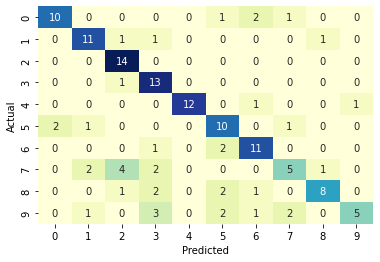

In [12]:
print("Performance of digit classification, NN, 0 manual labels")
# Observations update!
perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,\
            1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,\
            1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]),
        'prediction':np.array([0,1,2,3,4,0,3,7,2,9,0,1,2,3,4,5,6,7,3,9,0,1,2,3,4,5,6,3,8,9,6,1,2,3,6,5,5,2,8,3,0,8,2,3,4,5,5,7,3,5,0,\
            2,2,3,4,0,6,2,5,9,0,1,2,2,4,1,6,3,6,3,0,1,2,3,4,5,6,8,8,3,0,1,2,3,4,5,6,1,8,9,0,1,2,3,4,5,6,7,8,1,5,1,2,3,9,7,6,2,8,7,0,\
            1,2,3,4,5,6,2,8,7,6,1,2,3,4,5,6,1,8,5,7,3,2,3,4,5,6,7,5,6])}
contingency_matrix = pd.crosstab(perf['prediction'], perf['actual'], rownames=['Predicted'], colnames=['Actual'])
#print(contingency_matrix)
print("Sample size:",len(perf['actual']))
print("Accuracy=",np.sum([contingency_matrix[i][i] for i in range(10)]) / np.sum(np.sum(contingency_matrix)))
# Plot contingency matrix
import matplotlib.pyplot as plt
import seaborn as sn

plt.clf()
res = sn.heatmap(contingency_matrix.T, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.savefig("crosstab_pandas.png", bbox_inches='tight', dpi=100)
plt.show();

# Confusion matrix calculated manually
def cm(digits,classf):
    CM = np.array([[0]*10]*10)
    for i in range(len(digits)):
        CM[digits[i]][classf[i]] = CM[digits[i]][classf[i]] + 1
    return CM
#CM = cm(digits,classf)
#print("Confusion matrix =\n",CM)
#Difficulty recognizing 7, 8.     

## 6. To Do
* Try to make Enter work to finish entering correct label, reduce to one button 'Fix'

* Display chart with running accuracy rate.
* New class, int->str

* Test different hidden layers
* Insert dropoff after layers
* metrics = ['accuracy','auc'] in test -> .compile

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

Analysis:
* Is it worth saving correctly classified images for training?

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.